# 卷积神经网络

在本章节的练习中，我们将对卷积，池化，空间批量归一化等内容进行编码，并比较不同实现方式的执行效率。由于python语言运行效率太过缓慢，我们会在第八章的tensorflow介绍章节再次训练卷积网络，本章我们只需要针对卷积网络的各个模块进行编码练习即可。本章我们将逐步完成：
* 卷积前向传播编码练习
* 卷积反向传播编码练习
* 最大池化前向传播编码练习
* 最大池化反向传播编码练习
* 组合完整卷积层编码练习
* 空间批量归一化编码练习

In [1]:
#-*- coding: utf-8 -*-
import time
import numpy as np
import matplotlib.pyplot as plt
from classifiers.chapter6 import *
from utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] =(10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ 相对误差 """
    return np.max(np.abs(x - y) /(np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# 导入数据
data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## 卷积前向传播(简单版本)

卷积的前向传播过程，其实就是使用多个卷积核顺序扫描输入数据的过程。虽然思想简单，但对于实际编程而言可能就会比较有难度了。我们已经实现了前向传播最直观的版本，但执行效率十分低下，可读性也非常差。

In [3]:
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# 相对误差大约为 1e-12
print('测试 max_pool_backward_naive 函数:')
print('dx 误差: ', rel_error(dx, dx_num))

测试 max_pool_backward_naive 函数:
dx 误差:  3.275626262118968e-12


由于 Python 自身执行速度缓慢的原因，即使我们完全向量化卷积后，该执行效率也远远达不到我们的需求。比较有效的方法是将完全向量版本的卷积操作使用 Cython 转化为 C 语言执行，但 Windows下需要安装诸多依赖库，操作不太方使。此处只进行完全向量版本的执行。

## 快速卷积

执行下列代码，比较快速卷积与你实现的卷积操作

In [4]:
from classifiers.chapter6.cnn_layers import conv_forward_fast
from time import time

x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('测试 conv_forward_fast:')
print('慢速版本: %fs' %(t1 - t0))
print('快速版本: %fs' %(t2 - t1))
print('加速: %fx' %((t1 - t0) /(t2 - t1)))
print('误差: ', rel_error(out_naive, out_fast))

测试 conv_forward_fast:
慢速版本: 4.569356s
快速版本: 1.244883s
加速: 3.670510x
误差:  3.89496113023988e-11


## 快速池化操作

执行下列代码，比较快速池化与你实现的池化操作

In [5]:
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('测试 pool_forward_fast:')
print('慢速版本: %fs' %(t1 - t0))
print('快速版本: %fs' %(t2 - t1))
print('加速: %fx' %((t1 - t0) /(t2 - t1)))
print('误差: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\n测试 pool_backward_fast:')
print('慢速版本: %fs' %(t1 - t0))
print('快速版本: %fs' %(t2 - t1))
print('加速: %fx' %((t1 - t0) /(t2 - t1)))
print('dx 误差: ', rel_error(dx_naive, dx_fast))

测试 pool_forward_fast:
慢速版本: 0.009760s
快速版本: 0.005861s
加速: 1.665189x
误差:  0.0

测试 pool_backward_fast:
慢速版本: 0.020494s
快速版本: 0.014640s
加速: 1.399909x
dx 误差:  0.0


# 完整的卷积层

我们将卷积、ReLU和池化组合在一起，形成一层完整的卷积层。

In [6]:
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(
        x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(
        x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(
        x, w, b, conv_param, pool_param)[0], b, dout)

print('测试 conv_relu_pool')
print('dx 误差: ', rel_error(dx_num, dx))
print('dw 误差: ', rel_error(dw_num, dw))
print('db 误差: ', rel_error(db_num, db))

测试 conv_relu_pool
dx 误差:  4.788779820806906e-08
dw 误差:  1.4213812914502082e-09
db 误差:  7.989753683822969e-11


In [7]:
# 生成测试数据
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print('测试 conv_relu:')
print('dx 误差: ', rel_error(dx_num, dx))
print('dw 误差: ', rel_error(dw_num, dw))
print('db 误差: ', rel_error(db_num, db))

测试 conv_relu:
dx 误差:  1.5225915734358116e-08
dw 误差:  1.090045954938535e-09
db 误差:  5.516659294279198e-12


## 浅层卷积网络

接下来我们实现简单的浅层卷积网络，该网络由一层卷积层，两层全连接层组成：输入 - conv - relu - 2x2 max pool - affine - relu - affine - softmax。

### 损失函数检验

在不添加正则化的情况下，c分类任务，初始时的损失值应该接近于`log(c)`，运行下列代码进行损失值检验：

In [11]:
model = ThreeLayerConvNet()
N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('初始损失值所对应分类(无正则化): ', np.exp(loss))

model.reg = 0.5
loss, grads = model.loss(X, y)
print('初始损失值(正则化): ', loss)

初始损失值所对应分类(无正则化):  10.000002711556776
初始损失值(正则化):  2.508280195836654


### 梯度检验

运行下列代码进行梯度检验：

In [12]:
num_inputs = 2
input_dim =(3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(
        f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s 最大相对误差: %e' %(param_name, rel_error(
            param_grad_num, grads[param_name])))

W1 最大相对误差: 2.978425e-02
W2 最大相对误差: 1.612577e-02
W3 最大相对误差: 4.231643e-04
b1 最大相对误差: 1.587488e-05
b2 最大相对误差: 5.809691e-02
b3 最大相对误差: 1.120641e-09


### 过拟合小量数据

运行下列代码，确保在小数据集上出现明显的过拟合现象

In [16]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

trainer = Trainer(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                updater_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=5)
trainer.train()

(迭代 1 / 40) 损失值: 2.388168
(周期 0 / 20) 训练精度: 0.180000; 验证精度: 0.121000
(周期 1 / 20) 训练精度: 0.130000; 验证精度: 0.105000
(周期 2 / 20) 训练精度: 0.290000; 验证精度: 0.140000
(迭代 6 / 40) 损失值: 2.912659
(周期 3 / 20) 训练精度: 0.230000; 验证精度: 0.128000
(周期 4 / 20) 训练精度: 0.280000; 验证精度: 0.127000
(周期 5 / 20) 训练精度: 0.310000; 验证精度: 0.168000
(迭代 11 / 40) 损失值: 1.985540
(周期 6 / 20) 训练精度: 0.420000; 验证精度: 0.167000
(周期 7 / 20) 训练精度: 0.460000; 验证精度: 0.177000
(迭代 16 / 40) 损失值: 1.504879
(周期 8 / 20) 训练精度: 0.550000; 验证精度: 0.186000
(周期 9 / 20) 训练精度: 0.520000; 验证精度: 0.174000
(周期 10 / 20) 训练精度: 0.640000; 验证精度: 0.194000
(迭代 21 / 40) 损失值: 1.109133
(周期 11 / 20) 训练精度: 0.700000; 验证精度: 0.193000
(周期 12 / 20) 训练精度: 0.720000; 验证精度: 0.187000
(迭代 26 / 40) 损失值: 0.931523
(周期 13 / 20) 训练精度: 0.750000; 验证精度: 0.225000
(周期 14 / 20) 训练精度: 0.800000; 验证精度: 0.225000
(周期 15 / 20) 训练精度: 0.800000; 验证精度: 0.209000
(迭代 31 / 40) 损失值: 0.650131
(周期 16 / 20) 训练精度: 0.860000; 验证精度: 0.211000
(周期 17 / 20) 训练精度: 0.930000; 验证精度: 0.237000
(迭代 36 / 40) 损失值: 0.243213
(周期 

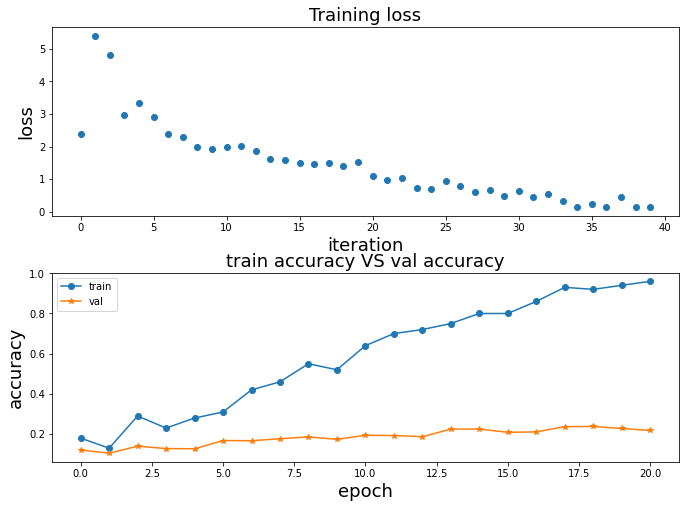

In [17]:
plt.subplot(2, 1, 1)
plt.title('Training loss',fontsize=18)
plt.plot(trainer.loss_history, 'o')
plt.xlabel('iteration',fontsize=18)
plt.ylabel('loss',fontsize=18)

plt.subplot(2, 1, 2)
plt.subplots_adjust(left=0.08, right=0.95, wspace=0.25, hspace=0.3)
plt.title('train accuracy VS val accuracy',fontsize=18)
plt.plot(trainer.train_acc_history, '-o')
plt.plot(trainer.val_acc_history, '-*')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch',fontsize=18)
plt.ylabel('accuracy',fontsize=18)
plt.show()

## 空间批量归一化

BN算法是一种非常高效的技术，大大加快的网络训练。但BN算法通常使用在全连接网络，因此在卷积网络中会有一点修改，我们将其称为"spatial batch normalization."

正常的BN接收(N,D)数据，现在我们需要将BN算法调整为接受(N,C,H,W)数据。
由于之前我们已经编写好了BN算法，你只需要将图片数据重塑成(N,D)然后调用我们实现好了的BN算法，之后再将其输出结果重塑回(N,C,H,W)


### SBN前向传播

In [18]:
#训练阶段：SBN前向传播
N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('使用BN之前:')
print('  数据形状: ', x.shape)
print('  均值: ', x.mean(axis=(0, 2, 3)))
print('  标准差: ', x.std(axis=(0, 2, 3)))


gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('使用BN后:')
print('  输出数据形状: ', out.shape)
print('  均值: ', out.mean(axis=(0, 2, 3)))
print('  标准差: ', out.std(axis=(0, 2, 3)))

gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('在BN后使用(gamma, beta)进行缩放:')
print('  输出数据形状: ', out.shape)
print('  均值: ', out.mean(axis=(0, 2, 3)))
print('  标准差: ', out.std(axis=(0, 2, 3)))

使用BN之前:
  数据形状:  (2, 3, 4, 5)
  均值:  [ 9.63110549 10.5177553   9.05513499]
  标准差:  [4.35307203 3.91791992 3.81445076]
使用BN后:
  输出数据形状:  (2, 3, 4, 5)
  均值:  [ 9.99200722e-17 -8.14712880e-16 -6.93889390e-16]
  标准差:  [0.99999974 0.99999967 0.99999966]
在BN后使用(gamma, beta)进行缩放:
  输出数据形状:  (2, 3, 4, 5)
  均值:  [6. 7. 8.]
  标准差:  [2.99999921 3.9999987  4.99999828]


In [20]:
#测试阶段：SBN前向传播
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)

for t in range(50):
    x = 2.3 * np.random.randn(N, C, H, W) + 13
    spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

print('  均值: ', a_norm.mean(axis=(0, 2, 3)))
print('  标准差: ', a_norm.std(axis=(0, 2, 3)))

  均值:  [0.02755273 0.03510479 0.04400864 0.02100596]
  标准差:  [1.03484001 0.98419223 1.01060769 1.01369932]


### SBN反向传播

In [21]:
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx 误差: ', rel_error(dx_num, dx))
print('dgamma 误差: ', rel_error(da_num, dgamma))
print('dbeta 误差: ', rel_error(db_num, dbeta))

dx 误差:  1.5952312994552347e-08
dgamma 误差:  4.433504952292138e-12
dbeta 误差:  4.0383999407118856e-12


## 训练卷积网络

In [ ]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=200, reg=0.001)

trainer = Trainer(model, data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                updater_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=2)
trainer.train()

(迭代 1 / 9800) 损失值: 2.303339
(周期 0 / 10) 训练精度: 0.101000; 验证精度: 0.119000
(迭代 3 / 9800) 损失值: 2.334345
(迭代 5 / 9800) 损失值: 2.399291
(迭代 7 / 9800) 损失值: 2.316727
(迭代 9 / 9800) 损失值: 2.278965
(迭代 11 / 9800) 损失值: 2.239781
(迭代 13 / 9800) 损失值: 2.089464
(迭代 15 / 9800) 损失值: 2.169326
(迭代 17 / 9800) 损失值: 2.117073
(迭代 19 / 9800) 损失值: 1.897549
(迭代 21 / 9800) 损失值: 2.044792
(迭代 23 / 9800) 损失值: 2.229730
(迭代 25 / 9800) 损失值: 2.279604
(迭代 27 / 9800) 损失值: 2.222372
(迭代 29 / 9800) 损失值: 2.022023
(迭代 31 / 9800) 损失值: 1.893715
(迭代 33 / 9800) 损失值: 1.886617
(迭代 35 / 9800) 损失值: 2.101612
(迭代 37 / 9800) 损失值: 2.048918
(迭代 39 / 9800) 损失值: 2.114011
(迭代 41 / 9800) 损失值: 2.034655
(迭代 43 / 9800) 损失值: 1.696890
(迭代 45 / 9800) 损失值: 2.004295
(迭代 47 / 9800) 损失值: 1.894582
(迭代 49 / 9800) 损失值: 1.915542
(迭代 51 / 9800) 损失值: 2.002454
(迭代 53 / 9800) 损失值: 2.029914
(迭代 55 / 9800) 损失值: 1.920715
(迭代 57 / 9800) 损失值: 1.811339
(迭代 59 / 9800) 损失值: 1.879020
(迭代 61 / 9800) 损失值: 1.987333
(迭代 63 / 9800) 损失值: 1.847146
(迭代 65 / 9800) 损失值: 1.911756
(迭代 6